In [1]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


In [2]:
pTrainData_fibrePrediction = 'train_prediction_grid_normalized_dti_cs1_wholebrain.h5'
pTrainData_fibreTracking = 'train_tracking_grid_normalized_dti_cs1_wholebrain.h5'
pTrainInput = 'train_input_normalized_dti_cs1_wholebrain_'
noCrossings = 3

# Data Handling

load bvec/bval and compute gradient table

In [166]:
bvals, bvecs = read_bvals_bvecs('100307/bvals', '100307/bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs)

crop multi-shell DWI to single shell data

In [185]:
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(1000, bvals, bvecs, dwi)

In [186]:
evecs_subset.shape

(90, 3)

compute spherical harmonics

In [187]:
import importlib
importlib.reload(dwi_tools)

<module 'src.dwi_tools' from '/home/nico/Code/deepFibreTracking/src/dwi_tools.py'>

In [181]:
bvals_subset.shape

(108,)

In [188]:
# Exract the averaged b0.
b0_idx = bvals < 10 # 10/02/18 NH: changed to work with HCP data
b0 = dwi[..., b0_idx].mean(axis=3)
data_sh, weights, b0 = dwi_tools.get_spherical_harmonics_coefficients(dwi_subset, b0=b0, bvals=bvals_subset, bvecs=bvecs_subset, sh_order = 4)

Nb. erroneous voxels: 5543007


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:49: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = weights / b0
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:49: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = weights / b0


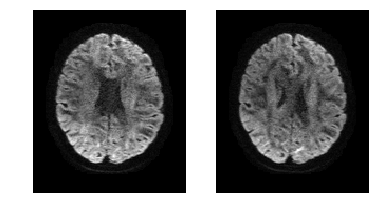

In [190]:
axial_middle = dwi_subset.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi_subset[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi_subset[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [191]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask, options = nrrd.read('100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
validationSeeds = ccseeds[45:48]

## Single Tensor Model

In [45]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_wls = dti.TensorModel(gtab_subset)
fit_wls = dti_wls.fit(dwi_subset)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 485.483589887619s


In [46]:
dwi_subset_tensors = fit_wls.evecs

peaks based on tensor model

In [48]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi_subset,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False,
                            nbr_processes=12
                           )
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 1993.2656157016754s


get eigenvectors and eigenvalues of the single tensor model

In [218]:
dataSz = np.append(fit_wls.evecs.shape[0:3],9)

In [219]:
data_evecs = np.concatenate((np.reshape(fit_wls.evecs, dataSz), fit_wls.evals), axis=3)

In [220]:
data_evecs.shape

(145, 174, 145, 12)

peaks based on spherical harmonics

In [ ]:
csa_model = CsaOdfModel(gtab_subset, sh_order=4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csa_peaks = peaks_from_model(model=csa_model,
                                     data=vol_masked,
                                     sphere=sphere,
                                     relative_peak_threshold=.5,
                                     min_separation_angle=25,
                                     mask=binarymask,
                                     return_odf=False,
                                     normalize_peaks=False,
                                     npeaks=5,
                                     parallel=True,
                                     nbr_processes=6)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')
classifier = ThresholdTissueClassifier(csa_peaks.gfa, .25)

reconstruct streamlines

In [52]:
from dipy.tracking.local import BinaryTissueClassifier
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .01)
binary_classifier = BinaryTissueClassifier(binarymask == 1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, np.identity(4), step_size=.1)
streamlines_generator = LocalTracking(dtipeaks, binary_classifier, ccseeds, aff, step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 40)

In [193]:
from dipy.tracking.streamline import transform_streamlines
#streamlines_imageCS = transform_streamlines(streamlines_filtered, np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system
dwi_tools.visStreamlines(streamlines_imageCS,t1, vol_slice_idx = 75)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Constrained Spherical Deconvolution

Use in case of b = 2,500 – 3,000 s/mm² data

In [ ]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csd_peaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .25)
streamlines_generator = LocalTracking(csd_peaks, classifier, ccseeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

### Store intermediate data

In [94]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_imageCS)
np.save(pTrainInput + "_seeds.npy",ccseeds)

# Generate Training data

In [95]:
del streamlines_filtered

#### ! TODO
    
Tracking:
    -> project seed into RAS cs
    -> do tracking in RAS
    -> project streamlines into image coordinate system

In [ ]:
streamlines_imageCS = np.load(pTrainInput + "_sl_filt.npy")

normalize DWI data

In [195]:
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)
dwi_B0normalized = dwi_tools.normalize_dwi(dwi_subset, b0)

Nb. erroneous voxels: 5543007


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:49: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = weights / b0
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:49: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = weights / b0


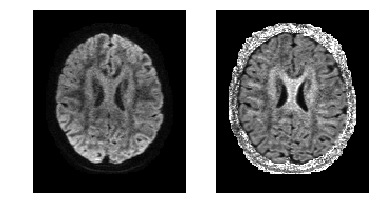

In [196]:
axial_middle = dwi_subset.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi_subset[:, :, axial_middle, 1].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi_B0normalized[:, :, axial_middle, 1].T, cmap='gray', origin='lower')
plt.show()

In [198]:
noX = 3
noY = 3
noZ = 3
coordinateScaling = 1

In [201]:
# SPHERICAL HARMONICS
import importlib
importlib.reload(dwi_tools)
import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

#rawData = data_evecs
rawData = data_sh

start_time = time.time()
train_DWI,train_prevDirection, train_LikelyFibreDirections, train_nextDirection = dwi_tools.generatePredictionNetworkTrainingDataFromStreamlines(streamlines_imageCS, rawData, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossings)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Generating training data
0/88786


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:417: RuntimeWarning: invalid value encountered in true_divide


1000/88786
2000/88786
3000/88786
4000/88786
5000/88786
6000/88786
7000/88786
8000/88786
9000/88786
10000/88786
11000/88786
12000/88786
13000/88786
14000/88786
15000/88786
16000/88786
17000/88786
18000/88786
19000/88786
20000/88786
21000/88786
22000/88786
23000/88786
24000/88786
25000/88786
26000/88786
27000/88786
28000/88786
29000/88786
30000/88786
31000/88786
32000/88786
33000/88786
34000/88786
35000/88786
36000/88786
37000/88786
38000/88786
39000/88786
40000/88786
41000/88786
42000/88786
43000/88786
44000/88786
45000/88786
46000/88786
47000/88786
48000/88786
49000/88786
50000/88786
51000/88786
52000/88786
53000/88786
54000/88786
55000/88786
56000/88786
57000/88786
58000/88786
59000/88786
60000/88786
61000/88786
62000/88786
63000/88786
64000/88786
65000/88786
66000/88786
67000/88786
68000/88786
69000/88786
70000/88786
71000/88786
72000/88786
73000/88786
74000/88786
75000/88786
76000/88786
77000/88786
78000/88786
79000/88786
80000/88786
81000/88786
82000/88786
83000/88786
84000/88786
8

/home/nico/Code/deepFibreTracking/src/dwi_tools.py:415: RuntimeWarning: invalid value encountered in true_divide


In [202]:
train_DWI.shape

(88786, 3, 3, 3, 15)

In [203]:
with h5py.File(pTrainData_fibrePrediction,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
    f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)   

## Training

In [76]:
noGPUs = 1
batch_size = 2**8
#batch_size -= batch_size % noGPUs # make batch size divisible by no. of GPUs
epochs = 50

In [125]:
f = h5py.File(pTrainData_fibrePrediction, "r")
train_DWI2 = np.array(f["train_DWI"].value)
train_prevDirection2 = np.array(f["train_curPosition"].value)
train_likelyDirections2 = np.array(f["train_LikelyFibreDirections"].value)
train_nextDirection2 = np.array(f["train_NextFibreDirection"].value)
f.close()
#train_lastDirection = np.expand_dims(train_lastDirection, axis=1)

### data normalization

In [ ]:
#train_LikelyFibreDirections = (train_LikelyFibreDirections + 1) / 2
#train_lastDirection = (train_lastDirection + 1) / 2
#train_DWI = nn_helper.normalizeDWI(train_DWI)
##train_lastDirection_unit = nn_helper.normalizeStreamlineOrientation(train_lastDirection)
##train_NextFibreDirection_unit = nn_helper.normalizeStreamlineOrientation(train_NextFibreDirection)

In [84]:
train_nextDirection_sph = dwi_tools.convAllToSphCoords(train_nextDirection)
train_prevDirection_sph = dwi_tools.convAllToSphCoords(train_prevDirection)
train_nextDirection_sph[:,1] = (train_nextDirection_sph[:,1] + np.pi) / (2 * np.pi)
train_prevDirection_sph[:,1] = (train_prevDirection_sph[:,1] + np.pi) / (2 * np.pi)

/home/nico/Code/deepFibreTracking/src/dwi_tools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.nan_to_num(np.arccos(z / r))


## MLP / Bidirectional

simple

In [ ]:
# w/ DROPOUT and BN
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 2048, inputShapeDWI=train_DWI.shape[1:5],depth = 5, noGPUs=noGPUs)
mlp_simple.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=2,validation_split=0.2, callbacks=[])

In [ ]:
# data scaled to [0,1]
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 128, inputShapeDWI=train_DWI.shape[1:5],depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

advanced

In [ ]:
# w/ DROPOUT and BN
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 2048, inputShapeDWI=train_DWI.shape[1:5],depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_adv = nn_helper.get_mlp_advancedTracker(activation_function = Activation('tanh'), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs, inputShapeStreamline=(3,1))
#mlp_adv.summary()
mlp_adv.fit([train_DWI,train_prevDirection], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1,validation_split=0.2, callbacks=[])

### UNET / Bidirectional

In [ ]:
from keras import backend as K

def relu_advanced(x):
    return K.relu(x, max_value=1)

In [ ]:
from keras import backend as K
import tensorflow as tf
# see https://openreview.net/pdf?id=Hkuq2EkPf
def swish(x, c = 0.1):
    return x * K.sigmoid(tf.constant(c, dtype=tf.float32) * x)

max normalized DWI data

In [ ]:
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
import importlib
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
#unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=2)
unet_tracker.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=20, verbose=1,validation_split=0.2, callbacks=[])

---

In [ ]:
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
import importlib
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
#unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=2)
unet_tracker.fit([train_DWI], [train_prevDirection_sph,train_nextDirection_sph], batch_size=batch_size, epochs=20, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
idx = 1
praw,eraw = unet_tracker.predict([train_DWI[idx:idx+1,]])
p = (2 * np.pi) * p - np.pi
e = (2 * np.pi) * e - np.pi
print(str(  np.mean(    (praw-train_prevDirection_sph[idx:idx+1,])**2            )))
print(str(  np.mean(    (eraw-train_nextDirection_sph[idx:idx+1,])**2            )))

In [ ]:
unet_tracker.evaluate([train_DWI[idx:idx+1,]], [train_prevDirection_sph[idx:idx+1,],train_nextDirection_sph[idx:idx+1,]])

In [ ]:
x,y,z = dwi_tools.spheToEuclidean(1,p[0,0],p[0,1])
print(str([x,y,z]))
print(str(train_prevDirection[idx,]))
xv,yv,zv = dwi_tools.spheToEuclidean(1,(2*np.pi)*train_prevDirection_sph[idx,0]+np.pi,(2*np.pi)*train_prevDirection_sph[idx,1]+np.pi)
print(str([xv,yv,zv]))

In [ ]:
np.sqrt(np.sum((praw - train_prevDirection_sph[idx,])**2))

In [ ]:
unet_tracker.save('trackingNetwork_unet.h5')

In [ ]:
# duenner Klassifikations-Layer
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = Activation(swish), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
#### learnable activation layer
from keras.engine.base_layer import Layer
class LearnableSwishActivation(Layer):
    def __init__(self, **kwargs):
        super(LearnableSwishActivation, self).__init__(**kwargs)
        self.__name__ = 'SWISH'
        
    def build(self, input_shape):
        self.output_dim = input_shape[1] 
        self.W = self.add_weight(shape=(1,), # Create a trainable weight variable for this layer.
                                 initializer='one', trainable=True, name="swish_c")
        super(LearnableSwishActivation, self).build(input_shape)  # Be sure to call this somewhere!
    def call(self, x, mask=None):
        return x * K.sigmoid(self.W * x)
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
import tensorflow as tf
x = tf.linspace(-5.,5.,10).eval(session=K.get_session())
y = swish(tf.linspace(-5.,5.,10),c=-0.1).eval(session=K.get_session())

In [ ]:
plt.plot(x,y);plt.show()

In [ ]:
# duenner Klassifikations-Layer, mit Dropout und BN
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = Activation(swish), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=200, verbose=1,validation_split=0.2, callbacks=[])

In [ ]:
import importlib
import keras
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
pModel = "tractography_model_{epoch:02d}-{val_loss:.6f}.h5"
#unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = keras.layers.core.Activation('relu'), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
csv_logger = CSVLogger("tractography_log.csv")
checkpoint = ModelCheckpoint(pModel, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint, csv_logger]
unet_tracker_2.fit([train_DWI], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1, validation_split=0.2, callbacks=[])

# DEBUG TRACKING

In [ ]:
noX = 16
noY = 16
noZ = 16

In [ ]:
import dipy.align.vector_fields as vfu
import tensorflow as tf
validationSeeds = ccseeds[0:1]
x_ = coordinateScaling * np.linspace(-8., 8., noX)
y_ = coordinateScaling * np.linspace(-8., 8., noY)
z_ = coordinateScaling * np.linspace(-8., 8., noZ)    
z_ = 1
noZ = 1

In [ ]:
noSeeds = len(validationSeeds)
noIterations = 1000
dw = 270

In [ ]:
streamlinePositions = np.zeros([noSeeds,noIterations+1,3])
streamlinePositions[:,0,] = validationSeeds[0:noSeeds]
streamlinePositions[:,1,] = validationSeeds[0:noSeeds]
x = np.zeros([noSeeds,noX,noY,noZ,dw])
iter = 1

In [ ]:
streamlinePositions[0,iter,]

In [ ]:
data=dwi_B0normalized
#model=msd_simple

In [ ]:
for j in range(0,noSeeds):
    coordVecs = np.vstack(np.meshgrid(x_,y_,z_, indexing='ij')).reshape(3,-1).T + streamlinePositions[j,iter,]
    for i in range(0,dw):
        x[j,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(data[:,:,:,i],coordVecs)[0], [noX,noY,noZ])

In [ ]:
from scipy.ndimage import map_coordinates

In [ ]:
values_tmp = map_coordinates(data[:,:,:,10], coordVecs.T, order = 1)

In [ ]:
vals = np.reshape(values_tmp, [noX,noY,noZ])

In [ ]:
np.max(vals)

In [ ]:
coordVecs[0]

In [ ]:
coordVecs[1]

In [ ]:
coordVecs[-1]

In [ ]:
streamlinePositions

In [ ]:
plt.figure('Showing the datasets')
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[62:78, 60:76, 62, 10].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(x[0,:,:,0,10].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[62:78, 60:76, 62, 10].T - x[0,:,:,0,10].T, cmap='gray', origin='lower')
plt.show()

In [ ]:
np.max(data[62:78, 60:76, 62, 10])

In [ ]:
np.max(x[0,:,:,0,10].T)

In [ ]:
np.min(data[62:78, 60:76, 62, 10].T - x[0,:,:,0,10].T)

In [ ]:
x.shape

In [ ]:
data.shape

In [ ]:
with tf.device('/cpu:0'):
    y2 = msd_simple.predict([x])
    #y3 = unet_tracker_2.predict([train_DWI[0:1,]])

In [ ]:
y2

In [ ]:
y2

In [ ]:
train_NextFibreDirection_unit[0]

In [ ]:
import keras
import keras.backend as K
keras.losses.mse(y,np.float32(train_NextFibreDirection_unit[0])).eval(session=K.get_session())

In [ ]:
from numpy import (array, dot, arccos, clip) 
from numpy.linalg import norm 

u = y
v = train_NextFibreDirection[0]
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
angle

In [ ]:
u = nn_helper.denormalizeStreamlineOrientation(u)
v = nn_helper.denormalizeStreamlineOrientation(v)
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
c

In [ ]:
yy = y / np.sqrt(np.sum(y ** 2))
yy

In [ ]:
vv = v / np.sqrt(np.sum(v ** 2))
vv

# Tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, validationSeeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines_val = Streamlines(streamlines_generator)
streamlines_filtered_val = dwi_tools.filterStreamlinesByLength(streamlines, 50)

## MLP/Bidirectional Tracker

In [ ]:
validationSeeds

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple,vNorms = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2,vNorms2 = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
streamlines_mlp_simple = streamlines_mlp_simple[0]
streamlines_mlp_simple_2 = streamlines_mlp_simple_2[0]
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 75, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

In [ ]:
np.save('streamlines_validation.npy', streamlines_val)

In [ ]:
streamlines_val = np.load('streamlines_validation.npy')

In [ ]:
dwi_tools.visStreamlines(streamlines_msd_adv,t1, vol_slice_idx = 73)

### UNET/Bidirectional tracker

In [ ]:
unet_tracker.save('trackingNetwork.h5')

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple,vNorms = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=unet_tracker, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2,vNorms2 = tracking.applySimpleTrackerNetwork(useSph=True,seeds=validationSeeds,data=dwi_B0normalized, model=unet_tracker, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 75, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

In [ ]:
plt.plot(vNorms.T)

In [ ]:
plt.plot(vNorms2.T)